<a href="https://colab.research.google.com/github/DanteBM/Aprendizaje-Profundo/blob/main/tareas/tarea1/tarea1d_ap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import numpy as np

from sklearn.model_selection import train_test_split

import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import CIFAR10

import torchvision.transforms as T
from tqdm import trange

import random
# tomar n elementos de una secuencia
from itertools import islice as take

## Pregunta 4: CIFAR 10
> Entrena una red completamente conectada para clasificación multiclase en el conjunto CIFAR10. Puedes usar todas las herramientas de PyTorch. (3 puntos.)

In [ ]:
images_path = "../datasets"
cifar_train_ds = CIFAR10(root=images_path, train=True, 
                      download=True, transform=T.ToTensor())
cifar_test_ds = CIFAR10(root=images_path, train=False, 
                     download=True, transform=T.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# tamaño del lote
BATCH_SIZE = 32

# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    # (batch x C x H x W)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # aplanamos canal
    x = x.reshape(*x.shape[:4])
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed(42)

x shape=torch.Size([32, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


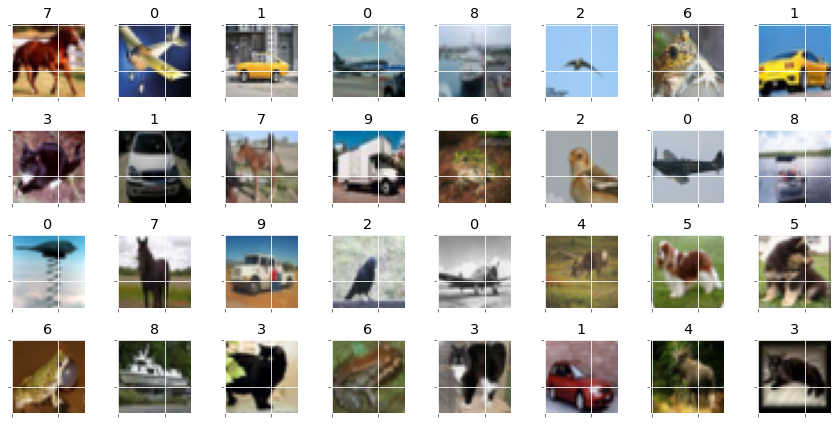

In [ ]:
# creamos un DataLoader
cifar_train_dl = DataLoader(
    # conjunto
    cifar_train_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(cifar_train_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

## Creación de dataloaders

In [ ]:
cifar_train_dl = DataLoader(
    # conjunto
    cifar_train_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

cifar_test_dl = DataLoader(
    # conjunto
    cifar_test_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

## Funciones auxiliares para entrenamiento

In [ ]:
dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dev # uso de GPU

device(type='cuda', index=0)

In [ ]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        x, y_true = x.to(dev), y_true.to(dev)
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):
            x, y_true = x.to(dev), y_true.to(dev)
            
            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

In [ ]:
def plot_evaluation(loss_hist, acc_hist):
    fig, ax = plt.subplots(ncols=2, figsize=(16,9))
    trn_loss, tst_loss = zip(*loss_hist)
    ax[0].plot(trn_loss, 'tab:orange', label='train loss')
    ax[0].plot(tst_loss, 'tab:red', label='test loss')
    ax[0].legend(loc='upper right')
    ax[0].set_xlabel('época')
    ax[0].set_ylabel('pérdida')
    
    trn_acc, tst_acc = zip(*acc_hist)
    ax[1].plot(trn_acc, 'tab:green', label='train acc')
    ax[1].plot(tst_acc, 'tab:blue', label='test acc')
    ax[1].legend(loc='lower right')
    ax[1].set_xlabel('época')
    ax[1].set_ylabel('exactitud')
    plt.show()

## Modelos

### Modelo 1: minimalista

In [ ]:
class CIFAR10Model1(nn.Module):
    
    # inicializador
    def __init__(self):
        
        # inicilización del objeto padre, obligatorio
        super().__init__()
        
        # tamaño de las capas
        self.I = 3 * 32 * 32
        FC1 = 128
        n_classes = 10
        
        # definición de capas
        self.cls = nn.Sequential(
            
            # fc1
            # [M, 1x28x28] => [M, 128]
            nn.Linear(self.I, FC1),
            nn.Sigmoid(),
            
            # fc2
            # [M, 128] => [M, 10]
            nn.Linear(FC1, n_classes)
        
        )
    
    # método para inferencia
    def forward(self, x):
        
        # aplanamos los pixeles de la imagen
        # [M, 1, 28, 28] => [M, 1x28x28]
        x = x.view(-1, self.I)
        
        # inferencia
        # [M, 1x28x28]
        x = self.cls(x)
        
        return x

In [ ]:
# instanciamos un modelo
cifar_model1 = CIFAR10Model1().to(dev)
# entrenamos
loss_hist, acc_hist = train(cifar_model1, cifar_train_dl, cifar_test_dl, epochs=100)

  1%|          | 1/100 [00:17<28:04, 17.01s/it]

E00 loss=[226.83,226.79] acc=[21.31,21.56]


  2%|▏         | 2/100 [00:28<22:33, 13.81s/it]

E01 loss=[223.54,223.49] acc=[24.78,25.51]


  3%|▎         | 3/100 [00:40<20:42, 12.81s/it]

E02 loss=[220.27,220.23] acc=[27.04,27.21]


  4%|▍         | 4/100 [00:51<19:30, 12.19s/it]

E03 loss=[217.03,216.99] acc=[26.88,26.89]


  5%|▌         | 5/100 [01:02<18:36, 11.75s/it]

E04 loss=[213.84,213.83] acc=[29.05,29.40]


  6%|▌         | 6/100 [01:13<18:01, 11.50s/it]

E05 loss=[210.97,210.96] acc=[29.49,29.36]


  7%|▋         | 7/100 [01:24<17:38, 11.38s/it]

E06 loss=[208.41,208.38] acc=[29.70,30.10]


  8%|▊         | 8/100 [01:35<17:13, 11.24s/it]

E07 loss=[206.13,206.10] acc=[30.16,30.30]


  9%|▉         | 9/100 [01:46<16:57, 11.18s/it]

E08 loss=[204.13,204.09] acc=[30.82,30.97]


 10%|█         | 10/100 [01:57<16:46, 11.18s/it]

E09 loss=[202.30,202.25] acc=[30.81,30.64]


 11%|█         | 11/100 [02:08<16:31, 11.14s/it]

E10 loss=[200.68,200.64] acc=[31.05,30.82]


 12%|█▏        | 12/100 [02:19<16:19, 11.13s/it]

E11 loss=[199.19,199.17] acc=[31.23,30.86]


 13%|█▎        | 13/100 [02:30<16:05, 11.10s/it]

E12 loss=[197.89,197.85] acc=[31.36,31.16]


 14%|█▍        | 14/100 [02:41<15:50, 11.05s/it]

E13 loss=[196.63,196.61] acc=[31.92,31.63]


 15%|█▌        | 15/100 [02:52<15:35, 11.00s/it]

E14 loss=[195.58,195.57] acc=[31.89,31.68]


 16%|█▌        | 16/100 [03:04<15:35, 11.14s/it]

E15 loss=[194.55,194.56] acc=[32.43,32.13]


 17%|█▋        | 17/100 [03:15<15:23, 11.13s/it]

E16 loss=[193.63,193.60] acc=[32.61,32.65]


 18%|█▊        | 18/100 [03:26<15:17, 11.18s/it]

E17 loss=[192.82,192.82] acc=[32.92,33.21]


 19%|█▉        | 19/100 [03:38<15:18, 11.34s/it]

E18 loss=[192.04,192.04] acc=[33.07,33.04]


 20%|██        | 20/100 [03:49<15:06, 11.33s/it]

E19 loss=[191.31,191.29] acc=[33.28,33.40]


 21%|██        | 21/100 [04:01<15:09, 11.52s/it]

E20 loss=[190.64,190.70] acc=[33.74,33.55]


 22%|██▏       | 22/100 [04:12<14:54, 11.47s/it]

E21 loss=[190.05,190.07] acc=[33.87,33.52]


 23%|██▎       | 23/100 [04:24<14:51, 11.58s/it]

E22 loss=[189.45,189.50] acc=[34.03,33.94]


 24%|██▍       | 24/100 [04:36<14:38, 11.56s/it]

E23 loss=[188.88,188.91] acc=[34.10,33.85]


 25%|██▌       | 25/100 [04:47<14:21, 11.49s/it]

E24 loss=[188.40,188.47] acc=[34.26,34.38]


 26%|██▌       | 26/100 [04:59<14:08, 11.46s/it]

E25 loss=[187.91,187.98] acc=[34.66,34.48]


 27%|██▋       | 27/100 [05:10<13:58, 11.49s/it]

E26 loss=[187.41,187.44] acc=[34.67,34.64]


 28%|██▊       | 28/100 [05:22<13:46, 11.47s/it]

E27 loss=[187.00,187.07] acc=[34.79,34.67]


 29%|██▉       | 29/100 [05:33<13:33, 11.46s/it]

E28 loss=[186.55,186.62] acc=[34.97,35.02]


 30%|███       | 30/100 [05:44<13:15, 11.37s/it]

E29 loss=[186.18,186.32] acc=[35.21,35.00]


 31%|███       | 31/100 [05:55<13:03, 11.35s/it]

E30 loss=[185.78,185.88] acc=[35.22,34.97]


 32%|███▏      | 32/100 [06:07<12:59, 11.46s/it]

E31 loss=[185.40,185.48] acc=[35.19,35.24]


 33%|███▎      | 33/100 [06:19<12:50, 11.49s/it]

E32 loss=[185.05,185.13] acc=[35.37,35.10]


 34%|███▍      | 34/100 [06:30<12:39, 11.51s/it]

E33 loss=[184.71,184.71] acc=[35.48,35.55]


 35%|███▌      | 35/100 [06:42<12:30, 11.54s/it]

E34 loss=[184.34,184.39] acc=[35.64,35.46]


 36%|███▌      | 36/100 [06:54<12:27, 11.67s/it]

E35 loss=[184.00,184.07] acc=[35.78,35.51]


 37%|███▋      | 37/100 [07:05<12:07, 11.54s/it]

E36 loss=[183.68,183.80] acc=[35.89,35.83]


 38%|███▊      | 38/100 [07:17<12:00, 11.62s/it]

E37 loss=[183.35,183.40] acc=[36.13,35.98]


 39%|███▉      | 39/100 [07:28<11:45, 11.57s/it]

E38 loss=[183.04,183.10] acc=[36.06,36.26]


 40%|████      | 40/100 [07:40<11:33, 11.56s/it]

E39 loss=[182.74,182.77] acc=[36.30,36.35]


 41%|████      | 41/100 [07:51<11:22, 11.58s/it]

E40 loss=[182.45,182.50] acc=[36.28,36.30]


 42%|████▏     | 42/100 [08:03<11:03, 11.44s/it]

E41 loss=[182.22,182.31] acc=[36.38,36.53]


 43%|████▎     | 43/100 [08:14<10:50, 11.42s/it]

E42 loss=[181.92,181.93] acc=[36.41,36.44]


 44%|████▍     | 44/100 [08:26<10:48, 11.58s/it]

E43 loss=[181.61,181.62] acc=[36.63,36.51]


 45%|████▌     | 45/100 [08:37<10:34, 11.55s/it]

E44 loss=[181.33,181.36] acc=[36.61,36.77]


 46%|████▌     | 46/100 [08:49<10:21, 11.51s/it]

E45 loss=[181.08,181.09] acc=[36.74,36.58]


 47%|████▋     | 47/100 [09:00<10:12, 11.56s/it]

E46 loss=[180.83,180.94] acc=[36.80,36.82]


 48%|████▊     | 48/100 [09:12<09:58, 11.52s/it]

E47 loss=[180.60,180.67] acc=[36.98,37.10]


 49%|████▉     | 49/100 [09:23<09:43, 11.44s/it]

E48 loss=[180.31,180.35] acc=[36.80,36.97]


 50%|█████     | 50/100 [09:35<09:35, 11.52s/it]

E49 loss=[180.07,180.10] acc=[37.16,37.05]


 51%|█████     | 51/100 [09:46<09:25, 11.53s/it]

E50 loss=[179.87,179.92] acc=[37.24,37.06]


 52%|█████▏    | 52/100 [09:58<09:11, 11.50s/it]

E51 loss=[179.60,179.64] acc=[37.21,37.50]


 53%|█████▎    | 53/100 [10:10<09:05, 11.62s/it]

E52 loss=[179.45,179.47] acc=[37.25,37.24]


 54%|█████▍    | 54/100 [10:21<08:51, 11.56s/it]

E53 loss=[179.16,179.17] acc=[37.39,37.58]


 55%|█████▌    | 55/100 [10:33<08:44, 11.65s/it]

E54 loss=[179.02,179.06] acc=[37.30,37.28]


 56%|█████▌    | 56/100 [10:45<08:31, 11.63s/it]

E55 loss=[178.74,178.78] acc=[37.58,37.64]


 57%|█████▋    | 57/100 [10:56<08:15, 11.51s/it]

E56 loss=[178.51,178.49] acc=[37.61,37.69]


 58%|█████▊    | 58/100 [11:07<08:02, 11.48s/it]

E57 loss=[178.36,178.42] acc=[37.56,37.60]


 59%|█████▉    | 59/100 [11:19<07:50, 11.47s/it]

E58 loss=[178.09,178.13] acc=[37.82,37.95]


 60%|██████    | 60/100 [11:30<07:36, 11.42s/it]

E59 loss=[177.94,177.91] acc=[37.79,37.87]


 61%|██████    | 61/100 [11:41<07:22, 11.36s/it]

E60 loss=[177.71,177.73] acc=[37.72,37.82]


 62%|██████▏   | 62/100 [11:53<07:13, 11.41s/it]

E61 loss=[177.54,177.60] acc=[38.09,38.09]


 63%|██████▎   | 63/100 [12:04<06:59, 11.35s/it]

E62 loss=[177.40,177.44] acc=[38.22,38.12]


 64%|██████▍   | 64/100 [12:15<06:49, 11.37s/it]

E63 loss=[177.16,177.20] acc=[38.24,38.19]


 65%|██████▌   | 65/100 [12:27<06:38, 11.39s/it]

E64 loss=[176.99,177.01] acc=[38.27,38.11]


 66%|██████▌   | 66/100 [12:38<06:25, 11.33s/it]

E65 loss=[176.76,176.81] acc=[38.32,38.35]


 67%|██████▋   | 67/100 [12:50<06:18, 11.48s/it]

E66 loss=[176.69,176.70] acc=[38.30,38.29]


 68%|██████▊   | 68/100 [13:01<06:05, 11.42s/it]

E67 loss=[176.45,176.53] acc=[38.56,38.50]


 69%|██████▉   | 69/100 [13:13<05:54, 11.42s/it]

E68 loss=[176.25,176.26] acc=[38.59,38.52]


 70%|███████   | 70/100 [13:24<05:40, 11.36s/it]

E69 loss=[176.07,176.07] acc=[38.46,38.49]


 71%|███████   | 71/100 [13:35<05:31, 11.45s/it]

E70 loss=[175.92,175.90] acc=[38.60,38.62]


 72%|███████▏  | 72/100 [13:47<05:21, 11.48s/it]

E71 loss=[175.76,175.82] acc=[38.70,38.55]


 73%|███████▎  | 73/100 [13:59<05:12, 11.58s/it]

E72 loss=[175.66,175.68] acc=[38.93,39.02]


 74%|███████▍  | 74/100 [14:10<05:01, 11.61s/it]

E73 loss=[175.42,175.44] acc=[38.97,38.78]


 75%|███████▌  | 75/100 [14:22<04:50, 11.60s/it]

E74 loss=[175.27,175.26] acc=[38.84,38.65]


 76%|███████▌  | 76/100 [14:34<04:40, 11.69s/it]

E75 loss=[175.09,175.15] acc=[38.97,38.98]


 77%|███████▋  | 77/100 [14:46<04:30, 11.74s/it]

E76 loss=[174.93,174.94] acc=[39.17,39.06]


 78%|███████▊  | 78/100 [14:57<04:15, 11.60s/it]

E77 loss=[174.79,174.87] acc=[38.99,38.97]


 79%|███████▉  | 79/100 [15:08<04:01, 11.52s/it]

E78 loss=[174.61,174.56] acc=[39.10,39.11]


 80%|████████  | 80/100 [15:20<03:52, 11.63s/it]

E79 loss=[174.50,174.60] acc=[39.22,39.17]


 81%|████████  | 81/100 [15:32<03:39, 11.56s/it]

E80 loss=[174.39,174.40] acc=[39.08,38.90]


 82%|████████▏ | 82/100 [15:43<03:26, 11.50s/it]

E81 loss=[174.17,174.21] acc=[39.35,39.30]


 83%|████████▎ | 83/100 [15:55<03:17, 11.61s/it]

E82 loss=[174.06,174.15] acc=[39.49,39.42]


 84%|████████▍ | 84/100 [16:06<03:04, 11.51s/it]

E83 loss=[173.87,173.89] acc=[39.46,39.44]


 85%|████████▌ | 85/100 [16:18<02:52, 11.47s/it]

E84 loss=[173.74,173.88] acc=[39.54,39.34]


 86%|████████▌ | 86/100 [16:29<02:42, 11.58s/it]

E85 loss=[173.57,173.62] acc=[39.41,39.64]


 87%|████████▋ | 87/100 [16:41<02:31, 11.68s/it]

E86 loss=[173.42,173.49] acc=[39.54,39.70]


 88%|████████▊ | 88/100 [16:53<02:19, 11.66s/it]

E87 loss=[173.28,173.39] acc=[39.49,39.46]


 89%|████████▉ | 89/100 [17:04<02:07, 11.62s/it]

E88 loss=[173.17,173.23] acc=[39.58,39.68]


 90%|█████████ | 90/100 [17:16<01:56, 11.64s/it]

E89 loss=[173.00,173.06] acc=[39.83,40.19]


 91%|█████████ | 91/100 [17:28<01:46, 11.79s/it]

E90 loss=[172.92,172.91] acc=[39.52,39.95]


 92%|█████████▏| 92/100 [17:40<01:34, 11.87s/it]

E91 loss=[172.69,172.74] acc=[39.76,39.87]


 93%|█████████▎| 93/100 [17:52<01:22, 11.75s/it]

E92 loss=[172.54,172.65] acc=[39.88,39.99]


 94%|█████████▍| 94/100 [18:03<01:09, 11.66s/it]

E93 loss=[172.43,172.53] acc=[40.15,40.11]


 95%|█████████▌| 95/100 [18:15<00:58, 11.76s/it]

E94 loss=[172.25,172.33] acc=[40.02,40.27]


 96%|█████████▌| 96/100 [18:27<00:47, 11.79s/it]

E95 loss=[172.13,172.20] acc=[40.10,40.30]


 97%|█████████▋| 97/100 [18:39<00:35, 11.69s/it]

E96 loss=[172.01,172.10] acc=[39.95,40.06]


 98%|█████████▊| 98/100 [18:51<00:23, 11.87s/it]

E97 loss=[171.97,172.10] acc=[40.31,40.14]


 99%|█████████▉| 99/100 [19:02<00:11, 11.78s/it]

E98 loss=[171.69,171.87] acc=[40.11,40.06]


100%|██████████| 100/100 [19:14<00:00, 11.55s/it]

E99 loss=[171.55,171.61] acc=[40.15,40.47]


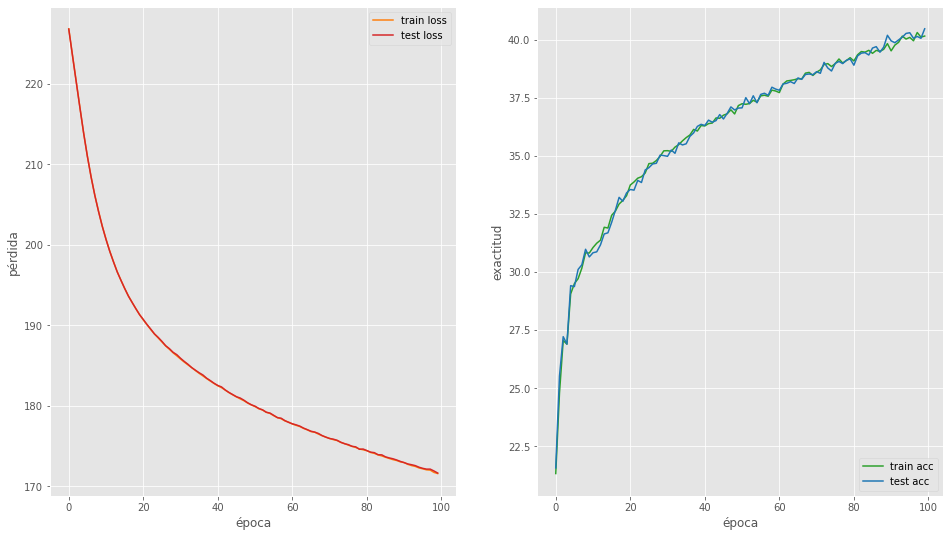

In [ ]:
plot_evaluation(loss_hist, acc_hist)

### Model 2

Se contempla más capas y el uso de la función ReLU

In [ ]:
class CIFAR10Model2(nn.Module):
    
    # inicializador
    def __init__(self):
        
        # inicilización del objeto padre, obligatorio
        super().__init__()
        
        # tamaño de las capas
        self.I = 3 * 32 * 32
        FC1 = 2*self.I + 1
        FC2 = self.I//2
        FC3 = FC2//2
        n_classes = 10
        
        # definición de capas
        self.cls = nn.Sequential(
            
            # fc1
            # [M, 1x28x28] => [M, 128]
            nn.Linear(self.I, FC1),
            nn.ReLU(),
            
            nn.Linear(FC1, FC2),
            nn.ReLU(),
            # fc2
            # [M, 128] => [M, 10]
            
            nn.Linear(FC2, FC3),
            nn.ReLU(),
            
            
            nn.Linear(FC3, n_classes)#,
            #nn.Softmax(dim=0)   
        )
    
    # método para inferencia
    def forward(self, x):
        
        # aplanamos los pixeles de la imagen
        # [M, 1, 28, 28] => [M, 1x28x28]
        x = x.view(-1, self.I)
        
        # inferencia
        # [M, 1x28x28]
        x = self.cls(x)
        
        return x

  1%|          | 1/100 [00:12<20:43, 12.56s/it]

E00 loss=[227.40,227.37] acc=[15.20,15.47]


  2%|▏         | 2/100 [00:24<20:22, 12.48s/it]

E01 loss=[222.42,222.42] acc=[19.25,19.81]


  3%|▎         | 3/100 [00:37<20:13, 12.51s/it]

E02 loss=[213.14,213.18] acc=[23.52,23.84]


  4%|▍         | 4/100 [00:50<20:03, 12.53s/it]

E03 loss=[205.16,205.17] acc=[26.66,27.03]


  5%|▌         | 5/100 [01:02<19:53, 12.56s/it]

E04 loss=[199.83,199.92] acc=[29.31,29.20]


  6%|▌         | 6/100 [01:15<19:44, 12.61s/it]

E05 loss=[195.36,195.48] acc=[30.19,29.94]


  7%|▋         | 7/100 [01:27<19:31, 12.60s/it]

E06 loss=[192.03,192.14] acc=[31.55,31.61]


  8%|▊         | 8/100 [01:40<19:29, 12.72s/it]

E07 loss=[189.21,189.42] acc=[32.82,32.37]


  9%|▉         | 9/100 [01:53<19:13, 12.67s/it]

E08 loss=[186.94,187.13] acc=[33.15,32.82]


 10%|█         | 10/100 [02:06<18:59, 12.66s/it]

E09 loss=[184.77,184.95] acc=[34.18,34.09]


 11%|█         | 11/100 [02:19<18:55, 12.76s/it]

E10 loss=[182.88,183.07] acc=[34.86,34.63]


 12%|█▏        | 12/100 [02:31<18:37, 12.70s/it]

E11 loss=[180.93,181.07] acc=[35.53,35.38]


 13%|█▎        | 13/100 [02:44<18:22, 12.68s/it]

E12 loss=[179.01,179.20] acc=[36.38,36.35]


 14%|█▍        | 14/100 [02:56<18:08, 12.66s/it]

E13 loss=[177.19,177.27] acc=[36.78,36.51]


 15%|█▌        | 15/100 [03:09<17:54, 12.64s/it]

E14 loss=[176.17,176.31] acc=[37.27,37.02]


 16%|█▌        | 16/100 [03:22<17:42, 12.64s/it]

E15 loss=[174.08,174.04] acc=[38.07,37.80]


 17%|█▋        | 17/100 [03:34<17:28, 12.63s/it]

E16 loss=[173.35,173.34] acc=[38.51,38.44]


 18%|█▊        | 18/100 [03:47<17:16, 12.64s/it]

E17 loss=[170.68,170.64] acc=[39.31,38.99]


 19%|█▉        | 19/100 [04:00<17:04, 12.64s/it]

E18 loss=[169.04,169.04] acc=[40.02,39.89]


 20%|██        | 20/100 [04:12<16:49, 12.61s/it]

E19 loss=[167.55,167.62] acc=[40.57,40.39]


 21%|██        | 21/100 [04:25<16:37, 12.62s/it]

E20 loss=[166.75,166.90] acc=[40.66,40.56]


 22%|██▏       | 22/100 [04:37<16:22, 12.60s/it]

E21 loss=[165.28,165.52] acc=[41.11,40.95]


 23%|██▎       | 23/100 [04:50<16:10, 12.61s/it]

E22 loss=[163.60,163.76] acc=[42.02,41.94]


 24%|██▍       | 24/100 [05:03<15:58, 12.61s/it]

E23 loss=[163.22,163.67] acc=[41.78,41.32]


 25%|██▌       | 25/100 [05:15<15:46, 12.62s/it]

E24 loss=[161.23,161.71] acc=[42.46,42.36]


 26%|██▌       | 26/100 [05:28<15:32, 12.60s/it]

E25 loss=[160.02,160.43] acc=[43.02,42.82]


 27%|██▋       | 27/100 [05:40<15:18, 12.58s/it]

E26 loss=[158.95,159.63] acc=[43.32,43.12]


 28%|██▊       | 28/100 [05:53<15:04, 12.57s/it]

E27 loss=[159.53,160.57] acc=[42.74,42.87]


 29%|██▉       | 29/100 [06:05<14:53, 12.59s/it]

E28 loss=[156.08,156.98] acc=[44.50,44.36]


 30%|███       | 30/100 [06:18<14:42, 12.61s/it]

E29 loss=[155.22,156.33] acc=[44.64,43.96]


 31%|███       | 31/100 [06:31<14:30, 12.62s/it]

E30 loss=[154.18,155.43] acc=[45.16,44.47]


 32%|███▏      | 32/100 [06:43<14:18, 12.63s/it]

E31 loss=[152.92,154.43] acc=[45.65,44.91]


 33%|███▎      | 33/100 [06:56<14:06, 12.63s/it]

E32 loss=[152.61,154.43] acc=[45.45,44.75]


 34%|███▍      | 34/100 [07:09<13:51, 12.60s/it]

E33 loss=[151.31,153.11] acc=[46.12,45.39]


 35%|███▌      | 35/100 [07:21<13:40, 12.62s/it]

E34 loss=[149.61,151.59] acc=[46.79,45.68]


 36%|███▌      | 36/100 [07:34<13:27, 12.61s/it]

E35 loss=[148.95,151.34] acc=[46.95,45.99]


 37%|███▋      | 37/100 [07:47<13:22, 12.73s/it]

E36 loss=[147.55,150.14] acc=[47.41,46.26]


 38%|███▊      | 38/100 [07:59<13:06, 12.68s/it]

E37 loss=[146.28,149.03] acc=[48.11,46.80]


 39%|███▉      | 39/100 [08:12<12:52, 12.66s/it]

E38 loss=[146.07,149.11] acc=[48.04,46.93]


 40%|████      | 40/100 [08:25<12:39, 12.65s/it]

E39 loss=[145.56,148.66] acc=[48.29,47.10]


 41%|████      | 41/100 [08:37<12:25, 12.64s/it]

E40 loss=[144.17,147.81] acc=[48.60,47.16]


 42%|████▏     | 42/100 [08:50<12:12, 12.64s/it]

E41 loss=[144.76,148.91] acc=[48.15,46.56]


 43%|████▎     | 43/100 [09:03<12:00, 12.64s/it]

E42 loss=[141.89,145.91] acc=[49.43,47.89]


 44%|████▍     | 44/100 [09:15<11:48, 12.65s/it]

E43 loss=[142.11,146.51] acc=[49.30,47.22]


 45%|████▌     | 45/100 [09:28<11:35, 12.64s/it]

E44 loss=[140.24,145.08] acc=[49.91,47.70]


 46%|████▌     | 46/100 [09:40<11:20, 12.61s/it]

E45 loss=[140.64,145.40] acc=[50.18,47.80]


 47%|████▋     | 47/100 [09:53<11:07, 12.59s/it]

E46 loss=[138.51,143.84] acc=[50.77,48.93]


 48%|████▊     | 48/100 [10:05<10:53, 12.57s/it]

E47 loss=[136.91,142.66] acc=[51.33,48.95]


 49%|████▉     | 49/100 [10:18<10:46, 12.69s/it]

E48 loss=[137.80,143.60] acc=[50.85,48.83]


 50%|█████     | 50/100 [10:31<10:31, 12.64s/it]

E49 loss=[137.03,143.17] acc=[51.18,49.35]


 51%|█████     | 51/100 [10:44<10:24, 12.75s/it]

E50 loss=[140.55,147.93] acc=[49.25,46.98]


 52%|█████▏    | 52/100 [10:57<10:10, 12.71s/it]

E51 loss=[136.23,143.79] acc=[51.52,49.05]


 53%|█████▎    | 53/100 [11:09<09:56, 12.69s/it]

E52 loss=[132.72,140.17] acc=[52.71,49.84]


 54%|█████▍    | 54/100 [11:22<09:42, 12.67s/it]

E53 loss=[132.12,140.11] acc=[52.89,49.64]


 55%|█████▌    | 55/100 [11:35<09:30, 12.68s/it]

E54 loss=[136.98,145.35] acc=[51.26,48.36]


 56%|█████▌    | 56/100 [11:47<09:15, 12.62s/it]

E55 loss=[132.01,140.89] acc=[52.65,49.61]


 57%|█████▋    | 57/100 [12:00<09:02, 12.61s/it]

E56 loss=[129.66,138.70] acc=[53.81,50.35]


 58%|█████▊    | 58/100 [12:12<08:50, 12.62s/it]

E57 loss=[131.94,141.41] acc=[52.94,49.42]


 59%|█████▉    | 59/100 [12:25<08:37, 12.63s/it]

E58 loss=[128.94,138.83] acc=[53.76,50.20]


 60%|██████    | 60/100 [12:38<08:25, 12.65s/it]

E59 loss=[130.77,141.28] acc=[52.85,49.52]


 61%|██████    | 61/100 [12:50<08:13, 12.65s/it]

E60 loss=[133.81,144.24] acc=[52.11,48.63]


 62%|██████▏   | 62/100 [13:03<08:00, 12.65s/it]

E61 loss=[126.18,137.46] acc=[54.93,51.14]


 63%|██████▎   | 63/100 [13:16<07:47, 12.64s/it]

E62 loss=[128.77,140.76] acc=[54.17,50.11]


 64%|██████▍   | 64/100 [13:28<07:34, 12.62s/it]

E63 loss=[126.76,138.67] acc=[54.57,50.51]


 65%|██████▌   | 65/100 [13:41<07:22, 12.65s/it]

E64 loss=[122.55,135.48] acc=[56.30,51.57]


 66%|██████▌   | 66/100 [13:53<07:10, 12.66s/it]

E65 loss=[124.47,137.34] acc=[55.84,51.36]


 67%|██████▋   | 67/100 [14:06<06:57, 12.66s/it]

E66 loss=[121.34,135.25] acc=[56.60,51.65]


 68%|██████▊   | 68/100 [14:19<06:44, 12.63s/it]

E67 loss=[123.79,137.53] acc=[55.89,51.31]


 69%|██████▉   | 69/100 [14:31<06:30, 12.60s/it]

E68 loss=[119.03,133.98] acc=[57.88,52.39]


 70%|███████   | 70/100 [14:44<06:22, 12.73s/it]

E69 loss=[119.40,134.71] acc=[57.42,52.35]


 71%|███████   | 71/100 [14:57<06:07, 12.68s/it]

E70 loss=[126.41,142.81] acc=[55.26,50.15]


 72%|███████▏  | 72/100 [15:10<05:54, 12.67s/it]

E71 loss=[124.06,140.62] acc=[56.10,50.55]


 73%|███████▎  | 73/100 [15:22<05:40, 12.63s/it]

E72 loss=[117.29,134.13] acc=[58.04,52.70]


 74%|███████▍  | 74/100 [15:35<05:28, 12.63s/it]

E73 loss=[119.73,137.72] acc=[57.63,51.31]


 75%|███████▌  | 75/100 [15:47<05:14, 12.58s/it]

E74 loss=[120.09,137.79] acc=[56.87,50.91]


 76%|███████▌  | 76/100 [16:00<05:02, 12.59s/it]

E75 loss=[115.76,134.43] acc=[58.24,51.80]


 77%|███████▋  | 77/100 [16:12<04:49, 12.60s/it]

E76 loss=[114.39,133.83] acc=[59.11,52.56]


 78%|███████▊  | 78/100 [16:25<04:37, 12.61s/it]

E77 loss=[111.56,131.20] acc=[60.26,53.18]


 79%|███████▉  | 79/100 [16:38<04:24, 12.59s/it]

E78 loss=[111.59,132.54] acc=[60.23,52.37]


 80%|████████  | 80/100 [16:50<04:11, 12.59s/it]

E79 loss=[112.71,133.63] acc=[59.82,52.91]


 81%|████████  | 81/100 [17:03<03:59, 12.60s/it]

E80 loss=[112.45,134.57] acc=[59.03,51.57]


 82%|████████▏ | 82/100 [17:15<03:46, 12.59s/it]

E81 loss=[112.51,134.64] acc=[60.06,52.55]


 83%|████████▎ | 83/100 [17:28<03:34, 12.60s/it]

E82 loss=[121.70,145.06] acc=[56.11,49.84]


 84%|████████▍ | 84/100 [17:41<03:21, 12.61s/it]

E83 loss=[109.20,133.36] acc=[61.04,52.66]


 85%|████████▌ | 85/100 [17:53<03:09, 12.62s/it]

E84 loss=[107.85,132.49] acc=[61.29,52.73]


 86%|████████▌ | 86/100 [18:06<02:58, 12.74s/it]

E85 loss=[111.84,137.08] acc=[60.16,52.28]


 87%|████████▋ | 87/100 [18:19<02:45, 12.71s/it]

E86 loss=[117.39,142.51] acc=[58.08,50.63]


 88%|████████▊ | 88/100 [18:32<02:32, 12.68s/it]

E87 loss=[105.43,131.88] acc=[62.47,53.87]


 89%|████████▉ | 89/100 [18:44<02:19, 12.65s/it]

E88 loss=[105.79,133.63] acc=[62.12,52.36]


 90%|█████████ | 90/100 [18:57<02:06, 12.61s/it]

E89 loss=[107.61,135.46] acc=[61.41,52.64]


 91%|█████████ | 91/100 [19:10<01:54, 12.74s/it]

E90 loss=[104.42,132.90] acc=[62.62,53.30]


 92%|█████████▏| 92/100 [19:22<01:41, 12.70s/it]

E91 loss=[109.87,140.00] acc=[60.43,51.08]


 93%|█████████▎| 93/100 [19:35<01:28, 12.66s/it]

E92 loss=[106.83,138.39] acc=[61.59,52.15]


 94%|█████████▍| 94/100 [19:47<01:15, 12.64s/it]

E93 loss=[104.17,136.08] acc=[62.58,52.58]


 95%|█████████▌| 95/100 [20:00<01:03, 12.64s/it]

E94 loss=[102.94,135.25] acc=[63.25,52.71]


 96%|█████████▌| 96/100 [20:13<00:50, 12.62s/it]

E95 loss=[ 99.89,132.62] acc=[64.55,53.59]


 97%|█████████▋| 97/100 [20:25<00:37, 12.61s/it]

E96 loss=[ 99.65,133.17] acc=[63.63,53.17]


 98%|█████████▊| 98/100 [20:38<00:25, 12.62s/it]

E97 loss=[ 96.51,131.13] acc=[65.83,54.05]


 99%|█████████▉| 99/100 [20:50<00:12, 12.62s/it]

E98 loss=[117.86,154.23] acc=[57.39,47.61]


100%|██████████| 100/100 [21:03<00:00, 12.64s/it]

E99 loss=[ 95.83,131.53] acc=[65.90,54.12]


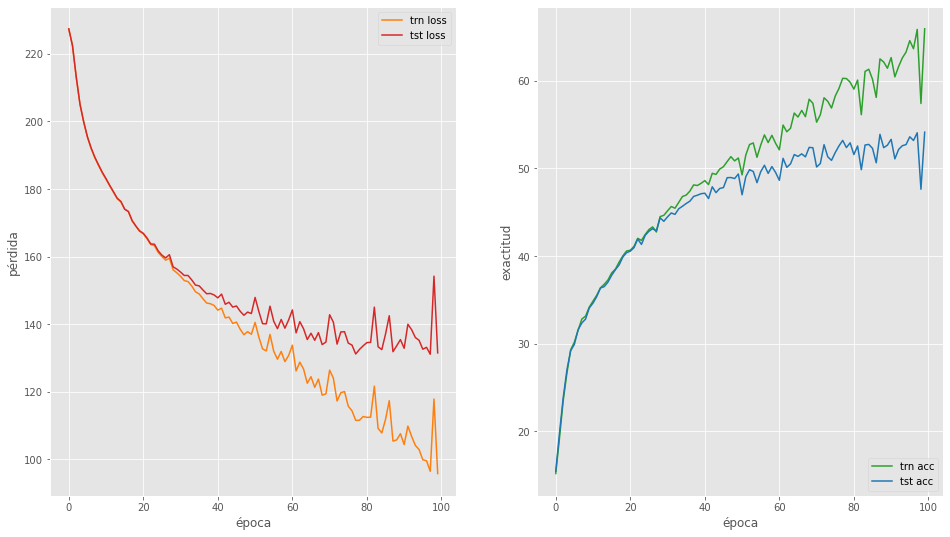

In [ ]:
# instanciamos un modelo
cifar_model2 = CIFAR10Model2().to(dev)
# entrenamos
loss_hist, acc_hist = train(cifar_model2, cifar_train_dl, cifar_test_dl, epochs=100)

plot_evaluation(loss_hist, acc_hist)

### Modelo 3

Debido a que el modelo anterior se tarda considerablemente, se plantea procesar la imagen, promediando sus canales, es decir, se realiza una transformación de color a escala de grises. La arquitectura es similar al del modelo pasado

In [ ]:
class CIFAR10Model3(nn.Module):
    
    # inicializador
    def __init__(self):
        
        # inicilización del objeto padre, obligatorio
        super().__init__()
        
        # tamaño de las capas
        self.I = 32 * 32
        FC1 = 2*self.I + 1
        FC2 = self.I//2
        FC3 = FC2//2
        n_classes = 10
        
        # definición de capas
        self.cls = nn.Sequential(
            
            # fc1
            # [M, 1x28x28] => [M, 128]
            nn.Linear(self.I, FC1),
            nn.ReLU(),
            
            nn.Linear(FC1, FC2),
            nn.ReLU(),
            # fc2
            # [M, 128] => [M, 10]
            
            nn.Linear(FC2, FC3),
            nn.ReLU(),
            
            
            nn.Linear(FC3, n_classes)#,
            #nn.Softmax(dim=0)   
        )
    
    # método para inferencia
    def forward(self, x):
        # Promediando canales
        x = x.mean(dim=1) # (batch, canal, ancho, alto)
        
        # aplanamos los pixeles de la imagen
        # [M, 1, 28, 28] => [M, 1x28x28]
        x = x.view(-1, self.I)
        
        # inferencia
        # [M, 1x28x28]
        x = self.cls(x)
        
        return x

  0%|          | 1/200 [00:12<39:54, 12.03s/it]

E00 loss=[229.31,229.32] acc=[11.45,11.50]


  1%|          | 2/200 [00:24<41:29, 12.57s/it]

E01 loss=[228.36,228.37] acc=[12.73,12.59]


  2%|▏         | 3/200 [00:37<41:24, 12.61s/it]

E02 loss=[226.99,227.02] acc=[17.60,17.57]


  2%|▏         | 4/200 [00:49<40:28, 12.39s/it]

E03 loss=[224.87,224.93] acc=[19.85,19.78]


  2%|▎         | 5/200 [01:02<40:51, 12.57s/it]

E04 loss=[221.83,221.95] acc=[20.23,20.38]


  3%|▎         | 6/200 [01:14<40:13, 12.44s/it]

E05 loss=[218.60,218.73] acc=[19.84,20.03]


  4%|▎         | 7/200 [01:26<39:40, 12.33s/it]

E06 loss=[216.30,216.42] acc=[20.79,20.64]


  4%|▍         | 8/200 [01:39<39:19, 12.29s/it]

E07 loss=[214.73,214.85] acc=[20.88,20.87]


  4%|▍         | 9/200 [01:51<39:32, 12.42s/it]

E08 loss=[213.31,213.45] acc=[22.20,22.46]


  5%|▌         | 10/200 [02:04<39:16, 12.40s/it]

E09 loss=[211.81,211.96] acc=[22.92,22.81]


  6%|▌         | 11/200 [02:16<38:52, 12.34s/it]

E10 loss=[210.21,210.35] acc=[23.34,23.72]


  6%|▌         | 12/200 [02:28<38:26, 12.27s/it]

E11 loss=[208.67,208.84] acc=[23.84,23.75]


  6%|▋         | 13/200 [02:40<38:06, 12.23s/it]

E12 loss=[207.02,207.26] acc=[25.24,25.23]


  7%|▋         | 14/200 [02:52<37:43, 12.17s/it]

E13 loss=[205.70,205.95] acc=[25.94,26.11]


  8%|▊         | 15/200 [03:04<37:30, 12.16s/it]

E14 loss=[204.52,204.79] acc=[26.76,27.09]


  8%|▊         | 16/200 [03:16<37:12, 12.13s/it]

E15 loss=[203.65,203.89] acc=[26.60,26.86]


  8%|▊         | 17/200 [03:28<36:50, 12.08s/it]

E16 loss=[202.71,203.00] acc=[27.18,27.60]


  9%|▉         | 18/200 [03:40<36:39, 12.08s/it]

E17 loss=[202.11,202.37] acc=[27.64,27.74]


 10%|▉         | 19/200 [03:53<36:31, 12.11s/it]

E18 loss=[201.10,201.40] acc=[27.67,27.96]


 10%|█         | 20/200 [04:05<36:52, 12.29s/it]

E19 loss=[200.35,200.68] acc=[28.06,28.41]


 10%|█         | 21/200 [04:17<36:36, 12.27s/it]

E20 loss=[199.74,200.04] acc=[28.51,28.54]


 11%|█         | 22/200 [04:30<36:41, 12.37s/it]

E21 loss=[198.97,199.27] acc=[28.63,28.80]


 12%|█▏        | 23/200 [04:42<36:21, 12.32s/it]

E22 loss=[198.23,198.54] acc=[28.80,28.90]


 12%|█▏        | 24/200 [04:55<36:33, 12.47s/it]

E23 loss=[197.47,197.82] acc=[29.18,29.36]


 12%|█▎        | 25/200 [05:07<36:15, 12.43s/it]

E24 loss=[196.85,197.18] acc=[29.44,29.54]


 13%|█▎        | 26/200 [05:21<36:44, 12.67s/it]

E25 loss=[196.15,196.60] acc=[29.77,29.94]


 14%|█▎        | 27/200 [05:33<36:25, 12.63s/it]

E26 loss=[195.32,195.69] acc=[29.91,30.15]


 14%|█▍        | 28/200 [05:46<35:55, 12.53s/it]

E27 loss=[194.75,195.15] acc=[30.36,30.54]


 14%|█▍        | 29/200 [05:58<35:26, 12.44s/it]

E28 loss=[193.85,194.23] acc=[30.97,31.12]


 15%|█▌        | 30/200 [06:11<35:38, 12.58s/it]

E29 loss=[193.17,193.57] acc=[30.82,31.10]


 16%|█▌        | 31/200 [06:23<35:06, 12.47s/it]

E30 loss=[192.36,192.80] acc=[31.22,31.19]


 16%|█▌        | 32/200 [06:35<34:43, 12.40s/it]

E31 loss=[191.52,191.99] acc=[31.53,31.57]


 16%|█▋        | 33/200 [06:47<34:18, 12.33s/it]

E32 loss=[190.86,191.23] acc=[32.02,32.14]


 17%|█▋        | 34/200 [06:59<33:52, 12.24s/it]

E33 loss=[190.09,190.62] acc=[32.03,32.02]


 18%|█▊        | 35/200 [07:12<33:38, 12.23s/it]

E34 loss=[189.22,189.72] acc=[32.39,32.29]


 18%|█▊        | 36/200 [07:24<33:54, 12.41s/it]

E35 loss=[188.36,188.81] acc=[32.52,32.64]


 18%|█▊        | 37/200 [07:37<34:02, 12.53s/it]

E36 loss=[187.48,188.01] acc=[33.38,33.15]


 19%|█▉        | 38/200 [07:49<33:36, 12.45s/it]

E37 loss=[186.70,187.22] acc=[33.50,33.31]


 20%|█▉        | 39/200 [08:02<33:13, 12.38s/it]

E38 loss=[185.92,186.55] acc=[33.83,33.54]


 20%|██        | 40/200 [08:14<32:54, 12.34s/it]

E39 loss=[185.21,185.77] acc=[34.06,33.87]


 20%|██        | 41/200 [08:26<32:38, 12.32s/it]

E40 loss=[184.78,185.37] acc=[34.25,34.05]


 21%|██        | 42/200 [08:39<32:46, 12.45s/it]

E41 loss=[183.57,184.13] acc=[34.76,34.67]


 22%|██▏       | 43/200 [08:51<32:24, 12.39s/it]

E42 loss=[183.01,183.73] acc=[34.83,34.58]


 22%|██▏       | 44/200 [09:04<32:12, 12.39s/it]

E43 loss=[182.73,183.42] acc=[35.03,34.80]


 22%|██▎       | 45/200 [09:16<32:13, 12.48s/it]

E44 loss=[181.46,182.25] acc=[35.37,35.14]


 23%|██▎       | 46/200 [09:28<31:51, 12.41s/it]

E45 loss=[180.64,181.49] acc=[35.58,35.19]


 24%|██▎       | 47/200 [09:41<31:23, 12.31s/it]

E46 loss=[180.59,181.33] acc=[35.61,35.18]


 24%|██▍       | 48/200 [09:53<30:59, 12.23s/it]

E47 loss=[179.09,179.98] acc=[36.20,35.94]


 24%|██▍       | 49/200 [10:05<30:34, 12.15s/it]

E48 loss=[178.45,179.43] acc=[36.24,36.06]


 25%|██▌       | 50/200 [10:17<30:15, 12.10s/it]

E49 loss=[177.96,179.06] acc=[36.48,36.06]


 26%|██▌       | 51/200 [10:29<29:58, 12.07s/it]

E50 loss=[177.41,178.36] acc=[36.56,36.29]


 26%|██▌       | 52/200 [10:41<29:45, 12.07s/it]

E51 loss=[177.35,178.46] acc=[36.72,36.08]


 26%|██▋       | 53/200 [10:53<29:28, 12.03s/it]

E52 loss=[176.39,177.68] acc=[36.95,36.46]


 27%|██▋       | 54/200 [11:05<29:17, 12.04s/it]

E53 loss=[175.23,176.52] acc=[37.43,36.88]


 28%|██▊       | 55/200 [11:17<29:05, 12.04s/it]

E54 loss=[174.86,176.32] acc=[37.41,36.99]


 28%|██▊       | 56/200 [11:28<28:45, 11.98s/it]

E55 loss=[173.98,175.54] acc=[37.79,36.74]


 28%|██▊       | 57/200 [11:40<28:29, 11.96s/it]

E56 loss=[173.98,175.61] acc=[37.65,37.37]


 29%|██▉       | 58/200 [11:53<28:32, 12.06s/it]

E57 loss=[172.81,174.65] acc=[38.08,37.35]


 30%|██▉       | 59/200 [12:05<28:27, 12.11s/it]

E58 loss=[172.43,174.23] acc=[38.17,37.40]


 30%|███       | 60/200 [12:17<28:22, 12.16s/it]

E59 loss=[171.21,173.19] acc=[38.80,38.01]


 30%|███       | 61/200 [12:29<28:08, 12.15s/it]

E60 loss=[170.85,173.06] acc=[38.73,37.54]


 31%|███       | 62/200 [12:41<27:54, 12.13s/it]

E61 loss=[170.00,172.36] acc=[39.23,38.22]


 32%|███▏      | 63/200 [12:54<27:43, 12.14s/it]

E62 loss=[169.76,172.11] acc=[38.98,38.27]


 32%|███▏      | 64/200 [13:06<27:54, 12.31s/it]

E63 loss=[170.33,172.78] acc=[39.15,38.26]


 32%|███▎      | 65/200 [13:18<27:31, 12.23s/it]

E64 loss=[168.92,171.72] acc=[39.21,38.17]


 33%|███▎      | 66/200 [13:30<27:09, 12.16s/it]

E65 loss=[168.46,171.16] acc=[39.93,38.93]


 34%|███▎      | 67/200 [13:42<26:56, 12.15s/it]

E66 loss=[167.32,170.28] acc=[40.25,39.00]


 34%|███▍      | 68/200 [13:55<26:54, 12.23s/it]

E67 loss=[168.00,170.94] acc=[40.18,38.92]


 34%|███▍      | 69/200 [14:07<26:34, 12.17s/it]

E68 loss=[166.70,169.89] acc=[40.50,38.96]


 35%|███▌      | 70/200 [14:19<26:15, 12.12s/it]

E69 loss=[165.84,169.27] acc=[40.71,39.34]


 36%|███▌      | 71/200 [14:31<25:59, 12.09s/it]

E70 loss=[166.03,169.73] acc=[40.68,39.00]


 36%|███▌      | 72/200 [14:43<25:45, 12.07s/it]

E71 loss=[164.56,168.45] acc=[41.14,39.20]


 36%|███▋      | 73/200 [14:55<25:43, 12.15s/it]

E72 loss=[164.10,168.04] acc=[41.21,39.59]


 37%|███▋      | 74/200 [15:08<25:42, 12.24s/it]

E73 loss=[164.11,168.18] acc=[41.49,39.31]


 38%|███▊      | 75/200 [15:20<25:46, 12.37s/it]

E74 loss=[164.48,168.72] acc=[41.29,39.47]


 38%|███▊      | 76/200 [15:33<25:55, 12.55s/it]

E75 loss=[163.79,168.43] acc=[41.27,39.41]


 38%|███▊      | 77/200 [15:47<26:06, 12.74s/it]

E76 loss=[164.49,169.41] acc=[40.95,38.89]


 39%|███▉      | 78/200 [15:59<26:00, 12.79s/it]

E77 loss=[161.74,166.76] acc=[42.29,39.64]


 40%|███▉      | 79/200 [16:12<25:38, 12.71s/it]

E78 loss=[160.76,165.70] acc=[42.57,40.51]


 40%|████      | 80/200 [16:25<25:33, 12.78s/it]

E79 loss=[160.45,165.64] acc=[42.44,40.06]


 40%|████      | 81/200 [16:38<25:17, 12.75s/it]

E80 loss=[159.07,164.41] acc=[43.18,40.76]


 41%|████      | 82/200 [16:50<24:54, 12.66s/it]

E81 loss=[160.21,165.74] acc=[42.92,40.59]


 42%|████▏     | 83/200 [17:03<24:36, 12.62s/it]

E82 loss=[159.04,164.75] acc=[43.36,40.81]


 42%|████▏     | 84/200 [17:15<24:14, 12.54s/it]

E83 loss=[157.36,163.50] acc=[43.68,40.84]


 42%|████▎     | 85/200 [17:27<23:50, 12.44s/it]

E84 loss=[157.47,163.57] acc=[43.94,41.02]


 43%|████▎     | 86/200 [17:40<23:38, 12.44s/it]

E85 loss=[166.55,172.70] acc=[40.65,37.86]


 44%|████▎     | 87/200 [17:53<23:44, 12.61s/it]

E86 loss=[156.83,163.67] acc=[44.15,40.86]


 44%|████▍     | 88/200 [18:05<23:40, 12.69s/it]

E87 loss=[156.01,163.19] acc=[44.07,41.19]


 44%|████▍     | 89/200 [18:18<23:32, 12.73s/it]

E88 loss=[156.84,163.88] acc=[43.94,41.30]


 45%|████▌     | 90/200 [18:31<23:10, 12.64s/it]

E89 loss=[159.29,166.94] acc=[43.06,39.88]


 46%|████▌     | 91/200 [18:44<23:12, 12.78s/it]

E90 loss=[157.18,165.33] acc=[43.81,40.64]


 46%|████▌     | 92/200 [18:57<23:01, 12.79s/it]

E91 loss=[153.95,161.98] acc=[44.95,41.48]


 46%|████▋     | 93/200 [19:09<22:50, 12.80s/it]

E92 loss=[155.14,163.33] acc=[44.44,41.28]


 47%|████▋     | 94/200 [19:22<22:26, 12.70s/it]

E93 loss=[155.37,164.10] acc=[44.54,41.06]


 48%|████▊     | 95/200 [19:34<22:08, 12.65s/it]

E94 loss=[155.45,164.18] acc=[44.29,41.13]


 48%|████▊     | 96/200 [19:47<21:47, 12.57s/it]

E95 loss=[162.09,171.23] acc=[41.91,38.89]


 48%|████▊     | 97/200 [20:00<21:39, 12.62s/it]

E96 loss=[152.25,161.66] acc=[45.84,41.75]


 49%|████▉     | 98/200 [20:13<21:40, 12.75s/it]

E97 loss=[150.82,160.42] acc=[45.87,41.91]


 50%|████▉     | 99/200 [20:25<21:14, 12.61s/it]

E98 loss=[149.98,159.69] acc=[46.23,42.35]


 50%|█████     | 100/200 [20:38<21:08, 12.68s/it]

E99 loss=[155.55,165.85] acc=[44.34,40.84]


 50%|█████     | 101/200 [20:50<20:45, 12.58s/it]

E100 loss=[148.89,159.59] acc=[46.63,42.38]


 51%|█████     | 102/200 [21:03<20:29, 12.54s/it]

E101 loss=[148.31,159.33] acc=[46.91,42.74]


 52%|█████▏    | 103/200 [21:16<20:28, 12.67s/it]

E102 loss=[149.40,160.41] acc=[46.43,42.29]


 52%|█████▏    | 104/200 [21:29<20:32, 12.84s/it]

E103 loss=[146.93,158.41] acc=[47.54,43.17]


 52%|█████▎    | 105/200 [21:41<20:11, 12.75s/it]

E104 loss=[146.79,158.61] acc=[47.24,42.50]


 53%|█████▎    | 106/200 [21:54<19:54, 12.71s/it]

E105 loss=[155.11,166.73] acc=[44.79,41.39]


 54%|█████▎    | 107/200 [22:07<19:40, 12.70s/it]

E106 loss=[146.52,158.87] acc=[47.69,43.06]


 54%|█████▍    | 108/200 [22:20<19:46, 12.90s/it]

E107 loss=[147.60,160.11] acc=[47.34,43.09]


 55%|█████▍    | 109/200 [22:33<19:25, 12.81s/it]

E108 loss=[145.04,157.95] acc=[48.14,43.50]


 55%|█████▌    | 110/200 [22:45<19:03, 12.71s/it]

E109 loss=[144.65,157.80] acc=[48.17,43.10]


 56%|█████▌    | 111/200 [22:58<18:50, 12.70s/it]

E110 loss=[150.57,164.85] acc=[45.96,41.14]


 56%|█████▌    | 112/200 [23:10<18:33, 12.65s/it]

E111 loss=[144.15,158.32] acc=[48.00,43.48]


 56%|█████▋    | 113/200 [23:23<18:19, 12.63s/it]

E112 loss=[146.14,160.75] acc=[47.70,43.01]


 57%|█████▋    | 114/200 [23:35<18:01, 12.57s/it]

E113 loss=[143.08,157.74] acc=[48.37,43.24]


 57%|█████▊    | 115/200 [23:48<17:58, 12.69s/it]

E114 loss=[141.32,156.27] acc=[49.49,43.79]


 58%|█████▊    | 116/200 [24:01<17:42, 12.64s/it]

E115 loss=[142.07,157.88] acc=[49.10,43.56]


 58%|█████▊    | 117/200 [24:13<17:24, 12.58s/it]

E116 loss=[155.37,171.27] acc=[44.31,40.07]


 59%|█████▉    | 118/200 [24:26<17:04, 12.50s/it]

E117 loss=[144.25,160.83] acc=[48.38,42.93]


 60%|█████▉    | 119/200 [24:38<16:51, 12.49s/it]

E118 loss=[142.79,159.23] acc=[48.47,43.20]


 60%|██████    | 120/200 [24:51<16:40, 12.51s/it]

E119 loss=[151.10,168.39] acc=[46.39,40.50]


 60%|██████    | 121/200 [25:03<16:28, 12.51s/it]

E120 loss=[137.82,155.79] acc=[50.72,44.52]


 61%|██████    | 122/200 [25:16<16:30, 12.69s/it]

E121 loss=[138.01,156.12] acc=[50.84,44.38]


 62%|██████▏   | 123/200 [25:29<16:25, 12.79s/it]

E122 loss=[140.96,159.23] acc=[49.41,43.21]


 62%|██████▏   | 124/200 [25:42<16:02, 12.66s/it]

E123 loss=[136.88,155.50] acc=[50.57,44.12]


 62%|██████▎   | 125/200 [25:54<15:42, 12.57s/it]

E124 loss=[134.63,153.48] acc=[51.85,44.92]


 63%|██████▎   | 126/200 [26:06<15:28, 12.55s/it]

E125 loss=[139.78,159.18] acc=[49.70,43.08]


 64%|██████▎   | 127/200 [26:19<15:09, 12.46s/it]

E126 loss=[145.58,165.13] acc=[47.67,41.78]


 64%|██████▍   | 128/200 [26:31<14:56, 12.45s/it]

E127 loss=[136.58,157.11] acc=[50.83,44.11]


 64%|██████▍   | 129/200 [26:44<14:53, 12.59s/it]

E128 loss=[136.48,157.07] acc=[50.86,44.05]


 65%|██████▌   | 130/200 [26:57<14:48, 12.69s/it]

E129 loss=[135.47,156.48] acc=[51.69,44.33]


 66%|██████▌   | 131/200 [27:09<14:26, 12.56s/it]

E130 loss=[136.62,158.02] acc=[51.09,44.01]


 66%|██████▌   | 132/200 [27:22<14:12, 12.54s/it]

E131 loss=[131.55,153.99] acc=[52.62,44.59]


 66%|██████▋   | 133/200 [27:35<14:07, 12.65s/it]

E132 loss=[131.20,154.01] acc=[52.73,45.23]


 67%|██████▋   | 134/200 [27:47<13:58, 12.70s/it]

E133 loss=[132.26,155.45] acc=[52.24,44.72]


 68%|██████▊   | 135/200 [28:00<13:44, 12.69s/it]

E134 loss=[132.70,156.41] acc=[52.30,44.27]


 68%|██████▊   | 136/200 [28:13<13:28, 12.64s/it]

E135 loss=[153.46,177.13] acc=[45.82,39.09]


 68%|██████▊   | 137/200 [28:26<13:24, 12.77s/it]

E136 loss=[132.67,157.54] acc=[52.59,44.00]


 69%|██████▉   | 138/200 [28:38<13:09, 12.74s/it]

E137 loss=[132.39,156.96] acc=[51.77,44.07]


 70%|██████▉   | 139/200 [28:51<12:59, 12.79s/it]

E138 loss=[129.27,154.95] acc=[53.89,45.16]


 70%|███████   | 140/200 [29:04<12:38, 12.65s/it]

E139 loss=[126.43,152.14] acc=[54.64,45.40]


 70%|███████   | 141/200 [29:16<12:25, 12.64s/it]

E140 loss=[142.68,170.09] acc=[48.82,41.15]


 71%|███████   | 142/200 [29:29<12:08, 12.56s/it]

E141 loss=[128.49,155.09] acc=[53.34,44.85]


 72%|███████▏  | 143/200 [29:41<12:00, 12.65s/it]

E142 loss=[127.38,155.01] acc=[53.93,44.90]


 72%|███████▏  | 144/200 [29:54<11:52, 12.73s/it]

E143 loss=[138.83,166.93] acc=[50.07,42.52]


 72%|███████▎  | 145/200 [30:07<11:32, 12.59s/it]

E144 loss=[124.28,152.93] acc=[55.25,45.76]


 73%|███████▎  | 146/200 [30:19<11:17, 12.55s/it]

E145 loss=[139.02,168.35] acc=[49.57,41.72]


 74%|███████▎  | 147/200 [30:32<11:12, 12.69s/it]

E146 loss=[123.94,153.75] acc=[55.09,45.36]


 74%|███████▍  | 148/200 [30:45<11:02, 12.73s/it]

E147 loss=[127.25,157.42] acc=[53.92,44.55]


 74%|███████▍  | 149/200 [30:57<10:45, 12.65s/it]

E148 loss=[125.87,157.11] acc=[54.91,44.70]


 75%|███████▌  | 150/200 [31:10<10:29, 12.58s/it]

E149 loss=[127.50,158.93] acc=[53.77,44.22]


 76%|███████▌  | 151/200 [31:22<10:11, 12.47s/it]

E150 loss=[140.82,172.78] acc=[49.26,41.13]


 76%|███████▌  | 152/200 [31:35<10:05, 12.61s/it]

E151 loss=[124.09,157.06] acc=[55.14,44.91]


 76%|███████▋  | 153/200 [31:47<09:50, 12.55s/it]

E152 loss=[131.81,165.14] acc=[52.10,42.54]


 77%|███████▋  | 154/200 [32:00<09:38, 12.57s/it]

E153 loss=[125.69,158.91] acc=[54.67,44.01]


 78%|███████▊  | 155/200 [32:12<09:23, 12.52s/it]

E154 loss=[125.30,159.48] acc=[55.05,44.15]


 78%|███████▊  | 156/200 [32:25<09:09, 12.48s/it]

E155 loss=[126.84,162.09] acc=[54.17,43.67]


 78%|███████▊  | 157/200 [32:37<08:55, 12.45s/it]

E156 loss=[119.47,154.95] acc=[56.42,45.62]


 79%|███████▉  | 158/200 [32:50<08:42, 12.45s/it]

E157 loss=[117.36,153.02] acc=[57.84,46.11]


 80%|███████▉  | 159/200 [33:02<08:31, 12.47s/it]

E158 loss=[120.15,156.38] acc=[56.64,45.43]


 80%|████████  | 160/200 [33:15<08:18, 12.47s/it]

E159 loss=[119.04,155.91] acc=[57.16,45.39]


 80%|████████  | 161/200 [33:27<08:11, 12.59s/it]

E160 loss=[115.52,152.72] acc=[58.42,46.37]


 81%|████████  | 162/200 [33:40<07:57, 12.55s/it]

E161 loss=[127.34,166.24] acc=[54.42,43.08]


 82%|████████▏ | 163/200 [33:53<07:48, 12.66s/it]

E162 loss=[118.07,157.10] acc=[57.22,45.08]


 82%|████████▏ | 164/200 [34:06<07:38, 12.73s/it]

E163 loss=[133.37,172.67] acc=[51.28,42.32]


 82%|████████▎ | 165/200 [34:19<07:26, 12.77s/it]

E164 loss=[134.54,176.35] acc=[51.80,41.07]


 83%|████████▎ | 166/200 [34:31<07:09, 12.62s/it]

E165 loss=[130.63,172.75] acc=[52.84,41.42]


 84%|████████▎ | 167/200 [34:44<06:58, 12.70s/it]

E166 loss=[118.83,160.75] acc=[57.05,44.43]


 84%|████████▍ | 168/200 [34:56<06:43, 12.62s/it]

E167 loss=[118.34,161.00] acc=[57.04,44.07]


 84%|████████▍ | 169/200 [35:09<06:30, 12.60s/it]

E168 loss=[131.38,175.34] acc=[52.44,41.10]


 85%|████████▌ | 170/200 [35:21<06:16, 12.56s/it]

E169 loss=[124.78,169.41] acc=[55.14,43.49]


 86%|████████▌ | 171/200 [35:34<06:07, 12.68s/it]

E170 loss=[124.81,169.17] acc=[55.13,43.32]


 86%|████████▌ | 172/200 [35:47<05:58, 12.79s/it]

E171 loss=[125.34,171.37] acc=[54.94,42.60]


 86%|████████▋ | 173/200 [36:00<05:41, 12.65s/it]

E172 loss=[109.33,154.23] acc=[60.90,46.22]


 87%|████████▋ | 174/200 [36:12<05:27, 12.60s/it]

E173 loss=[111.27,157.57] acc=[59.76,45.40]


 88%|████████▊ | 175/200 [36:25<05:18, 12.72s/it]

E174 loss=[126.55,173.40] acc=[53.60,42.38]


 88%|████████▊ | 176/200 [36:37<05:02, 12.62s/it]

E175 loss=[117.92,164.19] acc=[57.13,43.65]


 88%|████████▊ | 177/200 [36:50<04:47, 12.52s/it]

E176 loss=[111.97,160.27] acc=[59.66,44.92]


 89%|████████▉ | 178/200 [37:02<04:33, 12.45s/it]

E177 loss=[116.97,166.40] acc=[58.04,44.15]


 90%|████████▉ | 179/200 [37:14<04:21, 12.43s/it]

E178 loss=[107.27,156.44] acc=[61.70,45.79]


 90%|█████████ | 180/200 [37:27<04:08, 12.44s/it]

E179 loss=[104.34,153.37] acc=[62.75,46.72]


 90%|█████████ | 181/200 [37:40<03:59, 12.62s/it]

E180 loss=[108.90,160.27] acc=[61.16,45.46]


 91%|█████████ | 182/200 [37:52<03:45, 12.55s/it]

E181 loss=[113.99,166.15] acc=[58.57,44.33]


 92%|█████████▏| 183/200 [38:04<03:30, 12.37s/it]

E182 loss=[114.58,167.87] acc=[58.21,43.62]


 92%|█████████▏| 184/200 [38:16<03:15, 12.21s/it]

E183 loss=[105.96,158.67] acc=[62.05,46.14]


 92%|█████████▎| 185/200 [38:28<03:01, 12.11s/it]

E184 loss=[115.17,167.43] acc=[58.03,44.18]


 93%|█████████▎| 186/200 [38:40<02:48, 12.01s/it]

E185 loss=[108.59,163.26] acc=[59.83,44.92]


 94%|█████████▎| 187/200 [38:52<02:35, 11.99s/it]

E186 loss=[106.92,161.30] acc=[61.72,45.25]


 94%|█████████▍| 188/200 [39:03<02:23, 11.92s/it]

E187 loss=[102.25,156.51] acc=[62.99,46.62]


 94%|█████████▍| 189/200 [39:16<02:12, 12.02s/it]

E188 loss=[107.29,162.85] acc=[60.85,45.04]


 95%|█████████▌| 190/200 [39:28<02:00, 12.06s/it]

E189 loss=[132.29,188.67] acc=[52.45,41.02]


 96%|█████████▌| 191/200 [39:40<01:49, 12.12s/it]

E190 loss=[113.38,170.52] acc=[57.76,43.32]


 96%|█████████▌| 192/200 [39:53<01:38, 12.26s/it]

E191 loss=[105.06,162.72] acc=[61.10,44.84]


 96%|█████████▋| 193/200 [40:05<01:25, 12.23s/it]

E192 loss=[119.85,178.40] acc=[55.72,42.41]


 97%|█████████▋| 194/200 [40:17<01:12, 12.14s/it]

E193 loss=[ 98.82,157.94] acc=[64.31,46.58]


 98%|█████████▊| 195/200 [40:29<01:00, 12.06s/it]

E194 loss=[ 97.38,157.87] acc=[65.32,46.93]


 98%|█████████▊| 196/200 [40:41<00:48, 12.18s/it]

E195 loss=[104.52,166.92] acc=[62.16,44.84]


 98%|█████████▊| 197/200 [40:53<00:36, 12.15s/it]

E196 loss=[102.38,163.95] acc=[61.78,44.90]


 99%|█████████▉| 198/200 [41:05<00:24, 12.13s/it]

E197 loss=[ 97.60,160.70] acc=[65.23,46.34]


100%|█████████▉| 199/200 [41:17<00:12, 12.09s/it]

E198 loss=[104.64,168.62] acc=[61.37,43.76]


100%|██████████| 200/200 [41:29<00:00, 12.45s/it]

E199 loss=[113.99,180.42] acc=[58.70,42.05]


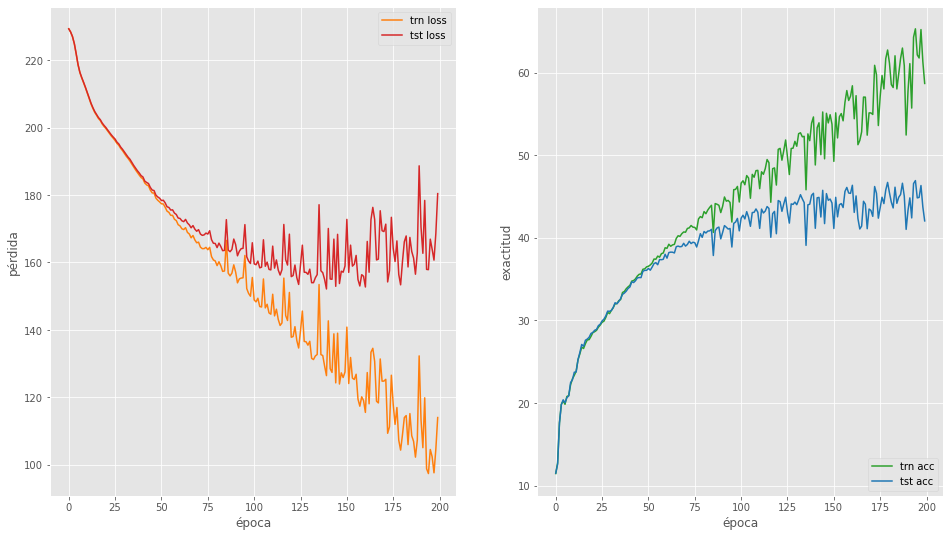

In [ ]:
# instanciamos un modelo
cifar_model3 = CIFAR10Model3().to(dev)
# entrenamos
loss_hist, acc_hist = train(cifar_model3, cifar_train_dl, cifar_test_dl, epochs=200)

plot_evaluation(loss_hist, acc_hist)

El mejor modelo fue el segundo, que es el que usa más parámetros y considera todos los pixeles de la imagen. Para el tercer modelo, se esperaba un desempeño parecido al segundo, pero con la ventaja de que tenía menos parámetros, ya que se convierten las imágenes de color a escala de grises (promediando los canales), sin embargo, el desempeño es ligeramente superior al del primer modelo. 

Para los últimos dos modelos también podemos observar que dejarlos entrenar por más épocas no será de ayuda, ya que en las gráficas se puede apreciar como la trayectoria del conjunto de pruebas (tanto para pérdida como exactitud) se empieza a estancar, y no mejorar, mientras que el de entrenamiento sigue. Se podría decir que las épocas son las suficientes para evitar el fenómeno de _overfitting_